In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
import renom as rm
from renom.optimizer import Adam
from renom.cuda import set_cuda_active
set_cuda_active(False)

In [6]:
def create_dataset(data, look_back, period, blank):
    X, y = [], []
    for i in range(len(data)-look_back-period-blank):
        X.append(data[i : i+look_back, :])
        watsum = sum(list(map(float,data[i+blank+look_back : i+look_back+blank+period][0])))
        y.append(watsum)
    n_features = np.array(X).shape[2]
    X = np.reshape(np.array(X), [-1, look_back, n_features])
    y = np.reshape(np.array(y), [-1, 1])
    return X, y

In [7]:
def split_data(X, y, test_size=0.1):
    pos = int(round(len(X) * (1-test_size)))
    X_train, y_train = X[:pos], y[:pos]
    X_test, y_test = X[pos:], y[pos:]
    return X_train, y_train, X_test, y_test

In [8]:
filename = "household_power_consumption.txt"
df = pd.read_csv(filename,sep=";", usecols=[2,3,4,5,6,7,8], low_memory=False)
print("the number of {} records:{}\n".format(filename, len(df.index)))
# df の要素の内、?を np.nan に変換、else はそのまま（引数のdに置き換える＝そのまま）
df = df.applymap(lambda d: np.nan if d=="?" else d)
# 上で np.nan にした要素をカウント
print("missing value info:\n{}\n".format(df.isnull().sum(axis=0)))
# 欠損地の削除
df = df.dropna(axis=0)
print("the number of {} records after trimming:{}\n".format(filename, len(df.index)))

ds = df.values.astype("float32")

the number of household_power_consumption.txt records:2075259

missing value info:
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

the number of household_power_consumption.txt records after trimming:2049280



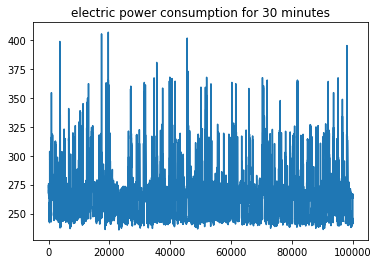

X_train:(67000, 30, 7),y_train:(67000, 1),X_test:(33000, 30, 7),y_test:(33000, 1)


In [12]:
# 正規化
def minmaxScaler(data, maxlist, minlist):
    for i in range(data.shape[-1]):
        if maxlist[i] - minlist[i] == 0:
            data[..., i] = 1
        else:
            data[..., i] = (data[..., i] - minlist[i]) / (maxlist[i] - minlist[i])
    return data

# 正規化から元に戻す
def undoScaler(data, maxlist, minlist):
    for i in range(data.shape[-1]):
        if maxlist[i] - minlist[i] == 0:
            data[..., i] = maxlist[i] * 1
        else:
            data[..., i] = data[..., i] * (maxlist[i] - minlist[i]) + minlist[i]
    return data

look_back = 30
blank = 60
period = 30
X, y = create_dataset(ds, look_back, period, blank)
X, y = X[:100000, :, :], y[:100000, :]
maxlist_data = np.max(X.reshape(X.shape[0]*X.shape[1], X.shape[2]), axis=0)
minlist_data = np.min(X.reshape(X.shape[0]*X.shape[1], X.shape[2]), axis=0)
maxlist_label = np.max(y).reshape(-1,1)
minlist_label = np.min(y).reshape(-1,1)
plt.plot(y)
plt.title("electric power consumption for 30 minutes")
plt.show()
X = minmaxScaler(X, maxlist_data, minlist_data)
y = minmaxScaler(y, maxlist_label, minlist_label)
X_train, y_train, X_test, y_test = split_data(X, y, 0.33)
print("X_train:{},y_train:{},X_test:{},y_test:{}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

sequential = rm.Sequential([
    rm.Lstm(20),
    rm.Dense(1)
])

batch_size = 2048
epoch = 30
N = len(X_train)
T = X_train.shape[1]

In [10]:
learning_curve = []
test_learning_curve = []
optimizer = Adam(lr=0.01)
for i in range(epoch):
    train_loss = 0
    test_loss = 0
    # 学習
    for j in range(N//batch_size):
        train_batch = X_train[j*batch_size : (j+1)*batch_size]
        response_batch = y_train[j*batch_size : (j+1)*batch_size]
        l = 0
        z = 0
        with sequential.train():
            for t in range(T):
                z = sequential(train_batch[:, t, :])
                l += rm.mse(z, response_batch)
            # あ、平均にしている（飛行機の乗客数予測では、していなかった）
            l /= T
            sequential.truncate()
        l.grad().update(optimizer)
        train_loss += l.as_ndarray()
    train_loss = train_loss / (N // batch_size)

    # 推論
    l_test = 0
    z = 0
    for t in range(T):
        z = sequential(X_test[:, t, :])
        l_test += rm.mse(z, y_test)
    l_test /= T
    test_loss = l_test.as_ndarray()
    sequential.truncate()
    print("epoch:{} train loss:{} test loss:{}".format(i, train_loss, test_loss))
    learning_curve.append(train_loss)
    test_learning_curve.append(test_loss)

epoch:0 train loss:0.006544001029396895 test loss:0.005303983110934496
epoch:1 train loss:0.005085019765829202 test loss:0.005080220755189657
epoch:2 train loss:0.005004471691790968 test loss:0.0050242021679878235
epoch:3 train loss:0.004999472075724043 test loss:0.004999628756195307
epoch:4 train loss:0.005003439924621489 test loss:0.004987814929336309
epoch:5 train loss:0.004997172538423911 test loss:0.00498569943010807
epoch:6 train loss:0.004981553880497813 test loss:0.004988689906895161
epoch:7 train loss:0.004963759780366672 test loss:0.004989974666386843
epoch:8 train loss:0.004949120666424278 test loss:0.00498956860974431
epoch:9 train loss:0.004938001813570736 test loss:0.004989069886505604
epoch:10 train loss:0.004929117665597005 test loss:0.004988701082766056
epoch:11 train loss:0.0049216684710700065 test loss:0.004988320637494326
epoch:12 train loss:0.004915289875498274 test loss:0.004987886641174555
epoch:13 train loss:0.004909758950816467 test loss:0.004987387452274561
ep

Root mean squared error:16.701172179464088


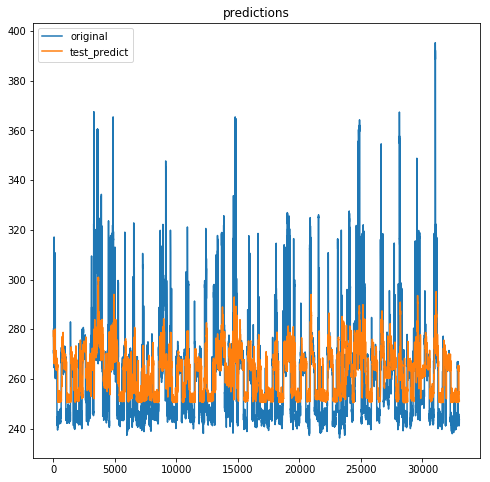

In [11]:
for t in range(T):
    test_predict = sequential(X_test[:, t, :])
sequential.truncate()
test_predict = np.array(test_predict)

y_test_raw = undoScaler(y_test.reshape(-1,1), maxlist_label, minlist_label)
test_predict_raw = undoScaler(test_predict.reshape(-1,1), maxlist_label, minlist_label)

print("Root mean squared error:{}".format(np.sqrt(mean_squared_error(y_test_raw, test_predict_raw))))

plt.figure(figsize=(8,8))
plt.title("predictions")
plt.plot(y_test_raw, label ="original")
plt.plot(test_predict_raw, label="test_predict")
plt.legend()
plt.show()